# WSDM Cup 2025: Multilingual Chatbot Arena

## Objective
The goal of this competition is to predict which chatbot response a user will prefer in a head-to-head battle between two chatbot models. This involves building a machine learning model to classify user preferences based on multilingual conversation data provided from the Chatbot Arena.

The competition encourages participants to explore various machine learning and natural language processing techniques to develop a model that can accurately predict user preferences while addressing potential biases in the data.

### Key Challenges:
1. Handling multilingual text data.
2. Addressing biases such as position bias, verbosity bias, and self-enhancement bias.
3. Ensuring generalization to unseen data in the forecasting phase.

### Evaluation:
Submissions will be evaluated based on accuracy, and predictions must be made for a test set with 25,000 rows. The submission should follow the prescribed format with the `id` and predicted `winner`.

### Deliverables:
- A trained machine learning model.
- Predictions for the test dataset in the correct format (`submission.csv`).
- Insights and methodologies for tackling biases and improving accuracy.
---
# Let's get started with exploring the data!


## Step 1: Load and Inspect the Dataset

In this step, we will:
1. Load the `train.parquet`, `test.parquet`, and `sample_submission.csv` files.
2. Inspect the structure of the datasets to understand their columns, data types, and any potential preprocessing requirements.


In [14]:
# Import required libraries
import pandas as pd

# Load datasets
train = pd.read_parquet('/kaggle/input/wsdm-cup-multilingual-chatbot-arena/train.parquet')
test = pd.read_parquet('/kaggle/input/wsdm-cup-multilingual-chatbot-arena/test.parquet')
sample_submission = pd.read_csv('/kaggle/input/wsdm-cup-multilingual-chatbot-arena/sample_submission.csv')

# Inspect the datasets
print("Train Dataset:")
print(train.info())
print(train.head())

print("\nTest Dataset:")
print(test.info())
print(test.head())

print("\nSample Submission:")
print(sample_submission.info())
print(sample_submission.head())


Train Dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48439 entries, 0 to 48438
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id          48439 non-null  object
 1   prompt      48439 non-null  object
 2   response_a  48439 non-null  object
 3   response_b  48439 non-null  object
 4   winner      48439 non-null  object
 5   model_a     48439 non-null  object
 6   model_b     48439 non-null  object
 7   language    48439 non-null  object
dtypes: object(8)
memory usage: 3.0+ MB
None
                                                  id  \
0  00007cff95d7f7974642a785aca248b0f26e60d3312fac...   
1  00010ed04b536f56ebe43eef1100c13906abea12bf9855...   
2  0003800d510e38803efba5ceaec122bc66408fe367b0be...   
3  00072026c68f5418ef2da238394e418ce72a534b9b22d5...   
4  0007ce7cf6bc1b5a8f8a4669b854fb12030863c970d9dc...   

                                              prompt  \
0                                 vieš 

## Step 2: Data Preprocessing
To prepare the dataset for modeling, we will:
1. Clean and tokenize the text data (`prompt`, `response_a`, `response_b`).
2. Handle multilingual data using pre-trained models (e.g., mBERT, XLM-RoBERTa).
3. Generate additional features, such as response lengths and similarity metrics.


In [15]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

# Basic preprocessing: Calculate response lengths
train['response_a_length'] = train['response_a'].apply(len)
train['response_b_length'] = train['response_b'].apply(len)
train['prompt_length'] = train['prompt'].apply(len)

# TF-IDF vectorization for responses
vectorizer = TfidfVectorizer(max_features=5000)
response_a_tfidf = vectorizer.fit_transform(train['response_a'])
response_b_tfidf = vectorizer.transform(train['response_b'])

# Calculate similarity between responses (using, cosine similarity)

train['response_similarity'] = [
    cosine_similarity(response_a_tfidf[i], response_b_tfidf[i])[0][0]
    for i in range(response_a_tfidf.shape[0])
]

# Display updated dataset
print(train[['response_a_length', 'response_b_length', 'response_similarity']].head())


   response_a_length  response_b_length  response_similarity
0                 48                194             0.000000
1               1414                183             0.253169
2               2179                899             0.670465
3                477               1799             0.762608
4               1282                404             0.047247


## Step 3: Exploratory Data Analysis (EDA)
In this step, we will:
1. Analyze the distributions of key features, such as response lengths and similarity scores.
2. Explore correlations between these features and the target variable (`winner`).
3. Visualize the data to gain deeper insights into potential biases or patterns.


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


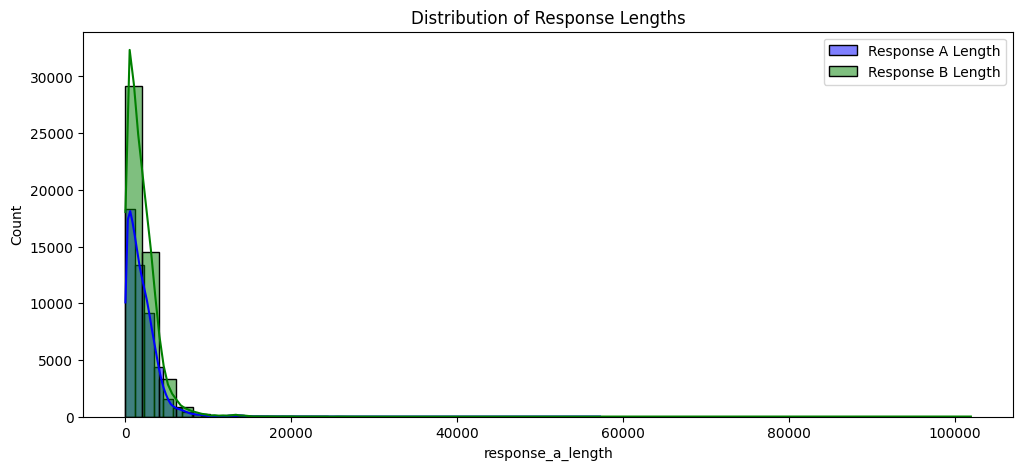

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


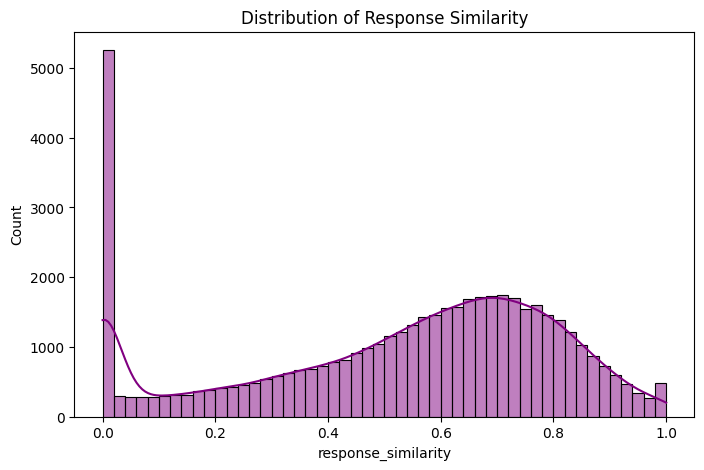

Feature Correlations:
                      response_a_length  response_b_length  response_similarity
response_a_length             1.000000           0.492103             0.238348
response_b_length             0.492103           1.000000             0.228165
response_similarity           0.238348           0.228165             1.000000


In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot distributions of response lengths
plt.figure(figsize=(12, 5))
sns.histplot(train['response_a_length'], bins=50, label='Response A Length', color='blue', kde=True)
sns.histplot(train['response_b_length'], bins=50, label='Response B Length', color='green', kde=True)
plt.legend()
plt.title('Distribution of Response Lengths')
plt.show()

# Plot distribution of response similarity
plt.figure(figsize=(8, 5))
sns.histplot(train['response_similarity'], bins=50, color='purple', kde=True)
plt.title('Distribution of Response Similarity')
plt.show()

# Correlation with winner
correlations = train[['response_a_length', 'response_b_length', 'response_similarity']].corr()
print("Feature Correlations:\n", correlations)


## Step 4: Feature Engineering
In this step, we will create additional features to capture the semantic, syntactic, and sentiment-based differences between `response_a` and `response_b`. These features will help our model better predict the `winner`.


In [17]:
from textblob import TextBlob
from sklearn.preprocessing import LabelEncoder

# Sentiment Analysis
train['sentiment_a'] = train['response_a'].apply(lambda x: TextBlob(x).sentiment.polarity)
train['sentiment_b'] = train['response_b'].apply(lambda x: TextBlob(x).sentiment.polarity)
train['sentiment_diff'] = train['sentiment_a'] - train['sentiment_b']

# Keyword Analysis
keywords = ['yes', 'no', 'sorry', 'thank you', 'please']
for keyword in keywords:
    train[f'response_a_contains_{keyword}'] = train['response_a'].str.contains(keyword, case=False, na=False).astype(int)
    train[f'response_b_contains_{keyword}'] = train['response_b'].str.contains(keyword, case=False, na=False).astype(int)

# Language Encoding
label_encoder = LabelEncoder()
train['language_encoded'] = label_encoder.fit_transform(train['language'])

# Response Politeness
politeness_keywords = ['please', 'thank you']
train['politeness_a'] = train['response_a'].apply(lambda x: any(kw in x.lower() for kw in politeness_keywords))
train['politeness_b'] = train['response_b'].apply(lambda x: any(kw in x.lower() for kw in politeness_keywords))

# Display updated dataset
print(train[['sentiment_a', 'sentiment_b', 'sentiment_diff', 'language_encoded', 'politeness_a', 'politeness_b']].head())


   sentiment_a  sentiment_b  sentiment_diff  language_encoded  politeness_a  \
0     0.000000       0.0000        0.000000                95         False   
1     0.007930      -0.2600        0.267930                87         False   
2    -0.750000      -0.1250       -0.625000               112         False   
3     0.000000       0.0000        0.000000                27         False   
4    -0.170276       0.2625       -0.432776                27         False   

   politeness_b  
0         False  
1         False  
2         False  
3         False  
4          True  


## Step 5: EDA for Engineered Features
Before building the baseline model, we will:
1. Analyze the distribution of `sentiment_a`, `sentiment_b`, and `sentiment_diff`.
2. Explore the frequency of politeness features and their potential impact on user preferences.


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


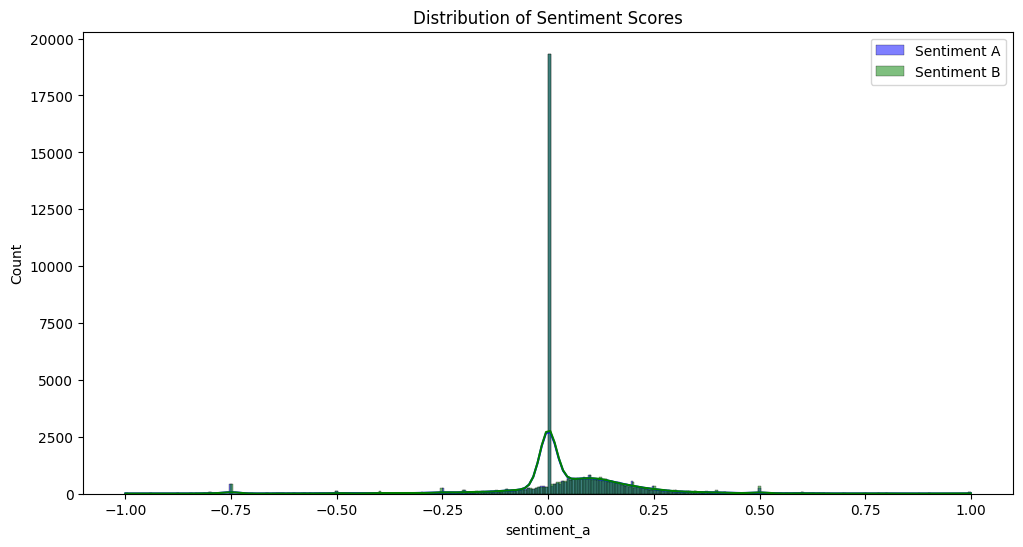

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


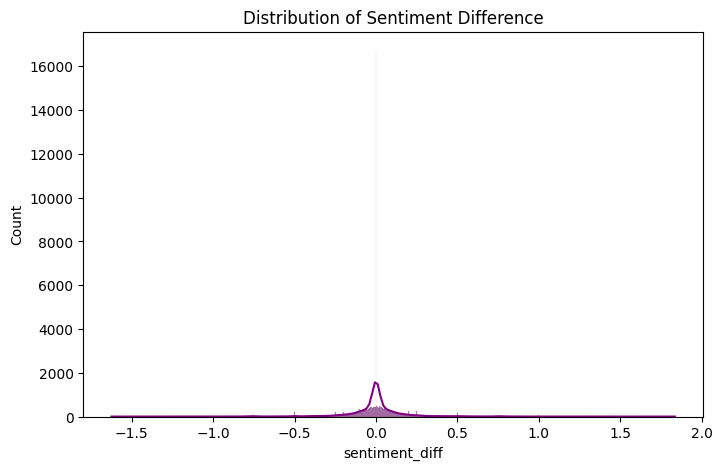

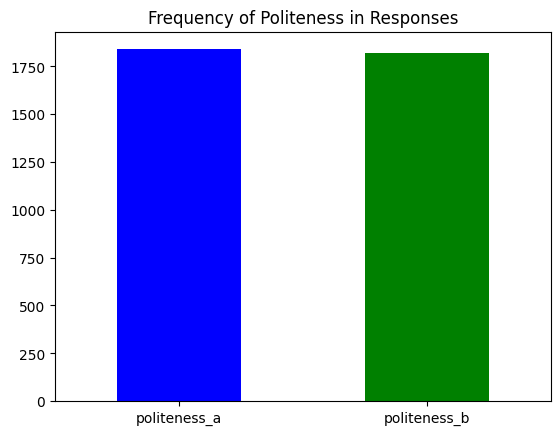

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

# Sentiment Distribution
plt.figure(figsize=(12, 6))
sns.histplot(train['sentiment_a'], color='blue', label='Sentiment A', kde=True)
sns.histplot(train['sentiment_b'], color='green', label='Sentiment B', kde=True)
plt.legend()
plt.title('Distribution of Sentiment Scores')
plt.show()

# Sentiment Difference
plt.figure(figsize=(8, 5))
sns.histplot(train['sentiment_diff'], color='purple', kde=True)
plt.title('Distribution of Sentiment Difference')
plt.show()

# Politeness Frequency
politeness_counts = train[['politeness_a', 'politeness_b']].sum()
politeness_counts.plot(kind='bar', color=['blue', 'green'])
plt.title('Frequency of Politeness in Responses')
plt.xticks(rotation=0)
plt.show()


## Step 6: Baseline Model
In this step, we will:
1. Prepare the dataset by consolidating features.
2. Train a baseline model (e.g., logistic regression or random forest) using engineered and original features.
3. Evaluate the model's performance using accuracy and cross-validation.


In [19]:
from sklearn.model_selection import train_test_split

# Prepare feature set and target variable
features = [
    'response_a_length', 'response_b_length', 'response_similarity',
    'sentiment_diff', 'language_encoded', 'politeness_a', 'politeness_b'
]
X = train[features]
y = train['winner'].apply(lambda x: 1 if x == 'model_a' else 0)  # Encode target

# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

print("Training Set Size:", X_train.shape)
print("Validation Set Size:", X_val.shape)


Training Set Size: (38751, 7)
Validation Set Size: (9688, 7)


## Step 7: Baseline Model Training and Evaluation
We will train a simple Logistic Regression model using the prepared features. The performance will be evaluated based on accuracy on the validation set.


In [20]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

# Train a Logistic Regression model
model = LogisticRegression(max_iter=1000, random_state=42)
model.fit(X_train, y_train)

# Predict on the validation set
y_pred = model.predict(X_val)

# Evaluate performance
accuracy = accuracy_score(y_val, y_pred)
print("Validation Accuracy:", accuracy)
print("\nClassification Report:")
print(classification_report(y_val, y_pred))


Validation Accuracy: 0.5720478943022296

Classification Report:
              precision    recall  f1-score   support

           0       0.58      0.59      0.59      4994
           1       0.56      0.55      0.56      4694

    accuracy                           0.57      9688
   macro avg       0.57      0.57      0.57      9688
weighted avg       0.57      0.57      0.57      9688



----
## Step 8: Feature Expansion with Pre-trained Embeddings
We will use XLM-RoBERTa to generate embeddings for `prompt`, `response_a`, and `response_b`. These embeddings will capture contextual and semantic information, which can improve the model's ability to predict user preferences.


In [21]:


# Reload pre-trained XLM-RoBERTa model and tokenizer
tokenizer = AutoTokenizer.from_pretrained("xlm-roberta-base")
model = AutoModel.from_pretrained("xlm-roberta-base")
model.eval()  # Set model to evaluation mode

# # Function to get embeddings in batches
# def get_embeddings_batch(texts, tokenizer, model, batch_size=64, device="cpu"):
#     embeddings = []
#     model.to(device)  # Move model to the correct device
#     for i in tqdm(range(0, len(texts), batch_size)):
#         batch = texts[i:i+batch_size]
#         encoded = tokenizer(batch, padding=True, truncation=True, return_tensors="pt", max_length=128)
#         with torch.no_grad():
#             outputs = model(**{k: v.to(device) for k, v in encoded.items()})  # Ensure inputs are on the same device
#         embeddings.append(outputs.last_hidden_state.mean(dim=1).cpu().numpy())  # Move output back to CPU
#     return np.vstack(embeddings)


# # Process embeddings in batches and save to disk
# batch_size = 64
# device = "cuda" if torch.cuda.is_available() else "cpu"

# # Prompt embeddings
# prompt_embeddings = get_embeddings_batch(train['prompt'].tolist(), tokenizer, model, batch_size, device)
# np.save("prompt_embeddings.npy", prompt_embeddings)

# # Response A embeddings
# response_a_embeddings = get_embeddings_batch(train['response_a'].tolist(), tokenizer, model, batch_size, device)
# np.save("response_a_embeddings.npy", response_a_embeddings)

# # Response B embeddings
# response_b_embeddings = get_embeddings_batch(train['response_b'].tolist(), tokenizer, model, batch_size, device)
# np.save("response_b_embeddings.npy", response_b_embeddings)


XLMRobertaModel(
  (embeddings): XLMRobertaEmbeddings(
    (word_embeddings): Embedding(250002, 768, padding_idx=1)
    (position_embeddings): Embedding(514, 768, padding_idx=1)
    (token_type_embeddings): Embedding(1, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): XLMRobertaEncoder(
    (layer): ModuleList(
      (0-11): 12 x XLMRobertaLayer(
        (attention): XLMRobertaAttention(
          (self): XLMRobertaSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): XLMRobertaSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine

In [22]:
from transformers import AutoTokenizer, AutoModel
import torch

import numpy as np
from tqdm import tqdm
from transformers import AutoTokenizer, AutoModel

In [23]:
prompt_embeddings = np.load("prompt_embeddings.npy")
response_a_embeddings = np.load("response_a_embeddings.npy")
response_b_embeddings = np.load("response_b_embeddings.npy")


## Step 9: Integrating Embeddings and Training an Enhanced Model

In this step, we will:
1. Integrate the embeddings generated from XLM-RoBERTa (`prompt_embeddings`, `response_a_embeddings`, `response_b_embeddings`) into the dataset.
2. Combine these embeddings with the existing features to create a comprehensive feature set.
3. Train a Random Forest Classifier on this enhanced dataset to evaluate the improvement in performance.


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
import numpy as np

# Combine embeddings with existing features
X_embeddings = np.hstack([
    prompt_embeddings,
    response_a_embeddings,
    response_b_embeddings,
])

# Combine embeddings with original features
X_combined = np.hstack([
    X.to_numpy(),  # Original feature set
    X_embeddings,  # Embedding features
])

print("Shape of Combined Features:", X_combined.shape)

# Train-test split for combined features
X_train_combined, X_val_combined, y_train, y_val = train_test_split(X_combined, y, test_size=0.2, random_state=42)

# Train a Random Forest Classifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_combined, y_train)

# Predict on validation set
y_pred_rf = rf_model.predict(X_val_combined)

# Evaluate model
rf_accuracy = accuracy_score(y_val, y_pred_rf)
print("Validation Accuracy with Embeddings:", rf_accuracy)
print("\nClassification Report:")
print(classification_report(y_val, y_pred_rf))


Shape of Combined Features: (48439, 2311)


## Step 10: Dimensionality Reduction with PCA
In this step, we will:
1. Apply PCA to reduce the dimensionality of the embedding features.
2. Retain only the top components that explain most of the variance.
3. Train the Random Forest model again with the reduced feature set.


In [ ]:
from sklearn.decomposition import PCA

# Apply PCA to embeddings
pca = PCA(n_components=50, random_state=42)  # Keep 50 components
X_embeddings_reduced = pca.fit_transform(X_embeddings)

# Combine reduced embeddings with original features
X_combined_reduced = np.hstack([
    X.to_numpy(),  # Original feature set
    X_embeddings_reduced,  # Reduced embedding features
])

print("Shape of Reduced Combined Features:", X_combined_reduced.shape)

# Train-test split for reduced feature set
X_train_reduced, X_val_reduced, y_train, y_val = train_test_split(
    X_combined_reduced, y, test_size=0.2, random_state=42
)

# Train a Random Forest Classifier
rf_model_reduced = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model_reduced.fit(X_train_reduced, y_train)

# Predict on validation set
y_pred_rf_reduced = rf_model_reduced.predict(X_val_reduced)

# Evaluate model
rf_accuracy_reduced = accuracy_score(y_val, y_pred_rf_reduced)
print("Validation Accuracy with Reduced Features:", rf_accuracy_reduced)
print("\nClassification Report:")
print(classification_report(y_val, y_pred_rf_reduced))


## Step 11: Training a Gradient Boosting Model
In this step, we will:
1. Train an XGBoost model using the reduced feature set from PCA.
2. Evaluate its performance on the validation set.
3. Compare its results with the Random Forest model.


In [ ]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report

# Train an XGBoost Classifier
xgb_model = XGBClassifier(
    n_estimators=100,  # Number of trees
    max_depth=6,       # Maximum tree depth
    learning_rate=0.1, # Step size shrinkage
    random_state=42,
    use_label_encoder=False,  # Avoid warnings
    eval_metric='logloss'     # Log loss metric
)

xgb_model.fit(X_train_reduced, y_train)

# Predict on validation set
y_pred_xgb = xgb_model.predict(X_val_reduced)

# Evaluate model
xgb_accuracy = accuracy_score(y_val, y_pred_xgb)
print("Validation Accuracy with XGBoost:", xgb_accuracy)
print("\nClassification Report:")
print(classification_report(y_val, y_pred_xgb))


## Step 12: Hyperparameter Tuning for XGBoost
In this step, we will:
1. Use RandomizedSearchCV to optimize key XGBoost hyperparameters.
2. Evaluate the tuned model's performance on the validation set.
3. Compare the results with the previous models.


In [ ]:
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV

# Reduced parameter grid
param_grid_optimized = {
    'n_estimators': [50, 100],
    'max_depth': [3, 6],
    'learning_rate': [0.05, 0.1],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'gamma': [0, 0.1]
}

# Initialize XGBoost model
xgb = XGBClassifier(
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)

# Randomized search with reduced grid
random_search_optimized = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_grid_optimized,
    n_iter=10,  # Try 10 random combinations
    scoring='accuracy',
    cv=3,  # 3-fold cross-validation
    random_state=42,
    n_jobs=-1,  # Use all CPU cores
    verbose=2
)

# Perform the search
random_search_optimized.fit(X_train_reduced, y_train)

# Best parameters and validation performance
best_params_optimized = random_search_optimized.best_params_
best_model_optimized = random_search_optimized.best_estimator_
y_pred_optimized = best_model_optimized.predict(X_val_reduced)

# Evaluate the tuned model
accuracy_optimized = accuracy_score(y_val, y_pred_optimized)
print("Best Parameters:", best_params_optimized)
print("Validation Accuracy with Optimized XGBoost:", accuracy_optimized)
print("\nClassification Report:")
print(classification_report(y_val, y_pred_optimized))
